# Face Morphing 


하나의 얼굴이미지를 다른 얼굴이미지로 변화하는 기법

In [1]:
# 레포 클론 
!git clone https://github.com/Azmarie/Face-Morphing.git
%cd Face-Morphing

fatal: destination path 'Face-Morphing' already exists and is not an empty directory.
/content/Face-Morphing


# Align image


images 폴더안에 모핑할 두개의 이미지 준비후 아래의 명령어 실행 

aligned_images에 정렬된 이미지가 저장됨 

In [2]:
!python ./code/utils/align_images.py images/ images/aligned_images --output_size=1024

Aligning aligned_images ...
Getting landmarks...
Exception in landmark detection!
Aligning seed0046.png ...
Getting landmarks...
Starting face alignment...
Wrote result images/aligned_images/seed0046_01.png
Aligning seed0073.png ...
Getting landmarks...
Starting face alignment...
Wrote result images/aligned_images/seed0073_01.png


에러나는 몇가지 함수 수정


In [7]:
# Import 할 수 있도록 PATH에 추가
import sys
sys.path.insert(0, "/content/Face-Morphing/code/")

In [8]:
from face_landmark_detection import generate_face_correspondences
from delaunay_triangulation import make_delaunay
from face_morph import morph_triangle

import cv2
import os
import dlib
import numpy as np
from PIL import Image

In [9]:
def generate_morph_sequence(frame,img1,img2,points1,points2,tri_list,output):

    for j in range(0, frame):

        # mat > float 변경 
        img1 = np.float32(img1)
        img2 = np.float32(img2)

        # 얼굴인식한 좌표 배열 가져오기
        points = []
        alpha = j/(frame-1)

        # 좌표들의 평균 가중치 계산 
        for i in range(0, len(points1)):
            x = (1 - alpha) * points1[i][0] + alpha * points2[i][0]
            y = (1 - alpha) * points1[i][1] + alpha * points2[i][1]
            points.append((x,y))
        
        morphed_frame = np.zeros(img1.shape, dtype = img1.dtype)

        for i in range(len(tri_list)):    
            x = int(tri_list[i][0])
            y = int(tri_list[i][1])
            z = int(tri_list[i][2])
            
            t1 = [points1[x], points1[y], points1[z]]
            t2 = [points2[x], points2[y], points2[z]]
            t = [points[x], points[y], points[z]]

            # 이미지1에서 이미지2로 삼각포인트에 변화를 주면서 섞는 함수 
            morph_triangle(img1, img2, morphed_frame, t1, t2, t, alpha)
            
            ''' 얼굴에 삼각line 그리고 싶으면 주석 풀기  
            # pt1 = (int(t[0][0]), int(t[0][1]))
            # pt2 = (int(t[1][0]), int(t[1][1]))
            # pt3 = (int(t[2][0]), int(t[2][1]))
            # cv2.line(morphed_frame, pt1, pt2, (255, 255, 255), 1, 8, 0)
            # cv2.line(morphed_frame, pt2, pt3, (255, 255, 255), 1, 8, 0)
            # cv2.line(morphed_frame, pt3, pt1, (255, 255, 255), 1, 8, 0)
            '''
            
        res = Image.fromarray(cv2.cvtColor(np.uint8(morphed_frame), cv2.COLOR_BGR2RGB))
        res.save(output+"res_"+str(j)+'.jpg','JPEG')


def doMorphing(img1, img2, frame_rate, output):

	# 얼굴인식하고 landmark point 얻기
	[size, img1, img2, points1, points2, list3] = generate_face_correspondences(img1, img2)
 
  # point들로 삼각형 만드는 함수 
	tri = make_delaunay(size[1], size[0], list3, img1, img2)

  # 모핑 후 저장
	generate_morph_sequence(frame_rate, img1, img2, points1, points2, tri, output)

# Do morphing 

doMorphing() 함수 실행하면 results/생성한 폴더에 결과물 저장

In [10]:
# align image 두개 경로 설정 
img_path1 = "./images/aligned_images/seed0046_01.png"
img_path2 = "./images/aligned_images/seed0073_01.png"
image1 = cv2.imread(img_path1)
image2 = cv2.imread(img_path2)

# 변환과정을 몇장으로 저장할건지 
frame = 20

# results 폴더 안에 각 시드 숫자 따와서 폴더생성
out1 = img_path1.split("/")[-1][5:8] 
out2 = img_path2.split("/")[-1][5:8]
output = f"./results/{out1}_{out2}/"
if not os.path.exists(output):   
  print("저장 폴더 생성")
  os.mkdir(output)


In [ ]:
# 모핑 실행 
doMorphing(image1, image2, frame, output)

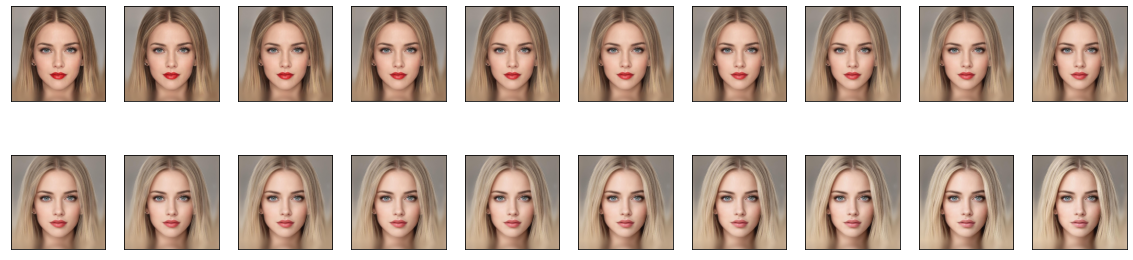

In [31]:
# 결과 이미지 보기 
import glob
import matplotlib.pyplot as plt
 
fig = plt.figure(figsize=(20, 5)) # rows*cols 행렬의 i번째 subplot 생성
rows = 2
cols = 10
i = 1

img_files = sorted(glob.glob("/content/Face-Morphing/results/046_073/*.jpg"), key=os.path.getctime)
 
for filename in img_files:
    img = cv2.imread(filename)
    ax = fig.add_subplot(rows, cols, i)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_xticks([]), ax.set_yticks([])
    i += 1
 
plt.show()



**gif로 저장(옵션)**

In [41]:
import imageio

# 저장할 이름 지정 
gif_name = r'morphing_video'
file_type = r'jpg'
# 이미지 변경 속도 
speed_sec = { 'duration' : 0.5}

images = []

for fname in img_files:
  if fname.endswith('.{}'.format(file_type)):
      file_path = os.path.join(output,fname)
      images.append(imageio.imread(file_path))

imageio.mimsave('{}/{}.gif'.format(output, gif_name), images, **speed_sec)